---
title: Sanitization Process for Data Privacy
authors:
- Juan Zinser 
tags:
- distributed
- data
- privacy
created_at: 2018-01-30
updated_at: 2018-01-30
tldr: This is short description of the content and findings of the post.
---

As good as data can be now a days, it must satisfy several requirements for it to be made public. A natural trade-off arises between privacy and utility of a dataset. On one side, depending on regulations and the data-holder carefulness, data satisfies certain privacy concerns to prevent sensitive information from being revealed. On the other side, for inference and conclusions to be taken from a dataset, data should be available for people whose interest is to analyze it. These analysis rely on data quality, and the more, the better for it's users. Work has been done to make sure data follows the corresponding privacy constraints, by generalization, suppression or sanitization techniques, with the aim of making data less informative (more private). The purpose of this work is to explore new ways of sanitization for databases and to measure their performance.

Motivation
Why is it important to make data public?

Data privacy exists because making data public is important, and it has to be taken care of before making it public. Open-Data is a term that refers to the action of Public or Private Institutions making their Data Public, and usually it helps to improve public policy and public services. An open data culture enhaces collaboration, participation and social innovation European Data Portal and Janssen, Marijin et al.

## Sanitize a dataset

In [9]:
#from dask import dataframe, delayed
#from dask.distributed import Client
import os
import math
import pandas as pd
import numpy as np
from sanitization_tools import *
#dataset_path = "/Users/juanzinser/Workspace/Tesis/data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
dataset_path = "/Users/juanzinser/Workspace/Tesis/data/kaggle/airline/airline-safety.csv"
#client = Client("0.0.0.0:8786")
#client = Client()
# read data


In [2]:
cases = [[1, True, True, True, False]]
for pr in range(1,11):
    cases += [[pr/10, False, True, True, False],
              [pr/10, True, True, True, False],
              [pr/10, True, False, False, False],
              [pr/10, False, False, False, False]]


In [3]:
data = pd.read_csv(dataset_path)

In [4]:
data.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [7]:
from sklearn import preprocessing, metrics, linear_model, metrics, svm, naive_bayes, tree
from IPython.display import display, clear_output
import time
import re

model_dict = dict()
model_dict["linear_regression"] = linear_model.LinearRegression()
model_dict["svm"] = svm.SVC(gamma=0.001, C=100.)
model_dict["naive_bayes"] = naive_bayes.GaussianNB()
model_dict["tree"] = tree.DecisionTreeRegressor()

processed_cases = list()
case_model_scores = dict()
reco_list = list()

iterator = 0
for case in cases:
    
    if iterator > 0:
        privacy, include_real, uniform, uniform2, maybe = case[0], case[1], case[2], case[3], case[4]
        case_name = str(privacy)+("m" if maybe else "t" if include_real else "f") + ("t" if uniform else "f")+("t" if uniform2 else "f")
    else:
        privacy, include_real, uniform, uniform2, maybe = 0, True, True, True, False
        case_name = "0ttt"
    
    if case_name not in processed_cases:
        for rand_num in range(10):
            case_name_rand = case_name +"_"+ str(rand_num)
            display(case_name_rand)
            #data = dataframe.read_csv(income_dataset_path, dtype={'Rating': 'float'})
            #data = dataframe.from_pandas(pd.read_csv(dataset_path), npartitions=1)
            #data = data.dropna()
            data = pd.read_csv(dataset_path)
            data = data.dropna()
            data = data[[col for col in data.columns if col not in ["lat", "lon", "hostel.name", "Distance"]]]
            data_cols = data.columns
            y_col = "fatalities_00_14"
            #data_y = data[y_col].compute()
            data_y = data[y_col]
            # print(len(data))
            # selects categorical data
            std_cols = list(set(data.select_dtypes(["number"]).columns).difference({y_col}))
            for col in std_cols:
                data[col] = pd.cut(data[col], bins=10, labels=False).map(str)
            cat_columns = list(set(data.select_dtypes(["bool_", "object_","flexible"],["number"]).columns).difference({y_col}))
            
            if iterator > 0:
                meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, False)
            else:
                meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, True)

            asd = {}
            rmse_dict = {}
            for col in cat_columns:
                if len(meta_info["columns"][col]["counter"])<50:
                    #asd[col] = client.gather(client.compute(data[col].map(lambda x: entry_sanitization(entry=x, **meta_info["algorithm"], **meta_info["columns"][col]), meta=('x', float))))
                    #asd[col] = data[col].map(lambda x: entry_sanitization(entry=x, **meta_info["algorithm"], **meta_info["columns"][col]))
                    asd[col] = np.matrix([entry_sanitization(entry=x, **meta_info["algorithm"], **meta_info["columns"][col]) for x in data[col]])
                    rmse_dict[col] = sum([np.power(x-y,2) for x,y in zip(meta_info["columns"][col]["counter"].values(), asd[col].sum(axis=0))])
            nis = pd.DataFrame.from_dict(rmse_dict, orient="index").reset_index()
            nis.columns = ["class", "rmse"]
            nis["case"] = case_name_rand
            reco_list.append(nis)
                
            #dataa =  pd.concat([pd.DataFrame([i for i in v.values], columns=[k+"/"+i for i in meta_info["columns"][k]["key_to_order"].keys()]) for k, v in asd.items()], axis=1)
            dataa =  pd.concat([pd.DataFrame(v, columns=[k+"/"+i for i in meta_info["columns"][k]["key_to_order"].keys()]) for k, v in asd.items()], axis=1)
            if len(data_y.unique())==2:
                dataa["y"] = (data_y==data_y.unique()[0]).astype(int)
            else: # in case there is numeric take the median
                dataa["y"] = (data_y>=sorted(data_y)[int(len(data_y)/2)]).astype(int)
                
            std_scaler = preprocessing.StandardScaler()
            #for col in std_cols:
                #dataa[col] = std_scaler.fit_transform(pd.DataFrame({col:data[col].compute().values}))
            #    dataa[col] = std_scaler.fit_transform(pd.DataFrame({col:data[col].values}))
            # apply a suppervised algorithm
            dataa = dataa.dropna()
            display(dataa.head())
            case_model_scores[case_name_rand] = dict()
            for model_name, model in model_dict.items():
                case_model_scores[case_name_rand][model_name] = get_auc_score_of_model(dataa, model)#[:2]
                display(model_name + str(case_model_scores[case_name_rand][model_name][:2]))
            #time.sleep(.5)
            clear_output(wait=True)
        processed_cases.append(case_name)
        iterator += 1


'0ttt_0'

,avail_seat_km_per_week/1,avail_seat_km_per_week/7,avail_seat_km_per_week/4,avail_seat_km_per_week/0,avail_seat_km_per_week/2,avail_seat_km_per_week/9,avail_seat_km_per_week/3,fatal_accidents_00_14/0,fatal_accidents_00_14/6,fatal_accidents_00_14/9,...,incidents_00_14/2,incidents_00_14/9,incidents_00_14/3,incidents_00_14/7,incidents_85_99/0,incidents_85_99/1,incidents_85_99/3,incidents_85_99/2,incidents_85_99/9,y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [72]:
ds_name="airline"

reco_df = pd.concat(reco_list)
reco_df.to_csv("supervised_rmse_df_"+ds_name+"011.csv")

df_models_scores = pd.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
df_models_scores = df_models_scores.melt(id_vars=df_models_scores.columns[0], value_vars=df_models_scores.columns[1:], value_name="models")
df_models_scores = pn.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
df_models_scores = df_models_scores.melt(id_vars=["case"]).rename(columns={"variable":"model"})
def get_privacy(x):
    if "." not in x:
        return 0
    else:
        return int("".join(re.findall("\d+", x)[:2]))
    
def get_real(x):
    if "." not in x:
        return re.findall("[^\d]",x)[0]
    else:
        return re.findall("[^\d]",x)[1]
    
def get_uniform1(x):
    if "." not in x:
        return int(re.findall("[^\d]",x)[1] == "t")
    else:
        return int(re.findall("[^\d]",x)[2] == "t")
    
def get_uniform2(x):
    if "." not in x:
        return int(re.findall("[^\d]",x)[2] == "t")
    else:
        return int(re.findall("[^\d]",x)[3] == "t")

df_models_scores["privacy"] = df_models_scores["case"].map(lambda x: get_privacy(x))
df_models_scores["real"] = df_models_scores["case"].map(lambda x: get_real(x))
df_models_scores["uniform"] = df_models_scores["case"].map(lambda x: get_uniform1(x))
df_models_scores["uniform2"] = df_models_scores["case"].map(lambda x: get_uniform2(x))

df_models_scores["error"] = df_models_scores["value"].map(lambda x: x[0])
df_models_scores["auc"] = df_models_scores["value"].map(lambda x: x[1])

def all_entries_vector(x):
    xs = ""
    for xi in x:
        xs += str(xi) + ","
    return xs[:-1]
    
df_models_scores["roc_x"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][0]))
df_models_scores["roc_y"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][1]))
df_models = df_models_scores[["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
df_models.columns = [["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
df_models.to_csv("model_scores_roc_"+ds_name+"011.csv")

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

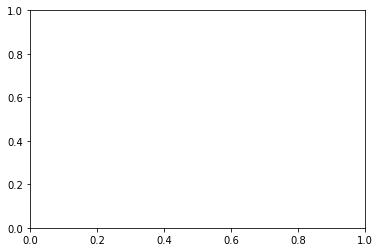

In [73]:

#supervised_results = pd.concat([pn.read_csv("model_scores_roc_census06_mbe.csv"), pd.read_csv("model_scores_roc_census611_mbe.csv")])
supervised_results = pn.read_csv("model_scores_roc_"+ds_name+"011.csv")
rocs_by_case(supervised_results, {},{"real":["t","f"]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")

print(supervised_results[supervised_results.real=="t"].groupby("privacy")["auc"].agg(lambda x:np.average(x)))


plot_intervals(supervised_results, "privacy","auc", {"uniform":[0], "uniform2":[0]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Proportional", save_name=ds_name+"_auc_real_proportional")
plot_intervals(supervised_results, "privacy","auc", {"uniform":[1], "uniform2":[1]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Uniform", save_name=ds_name+"_auc_real_uniform")

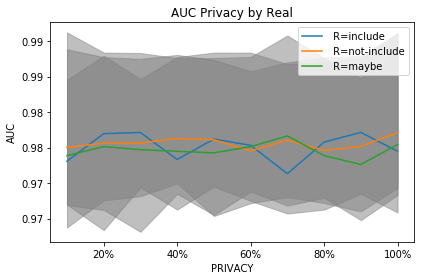

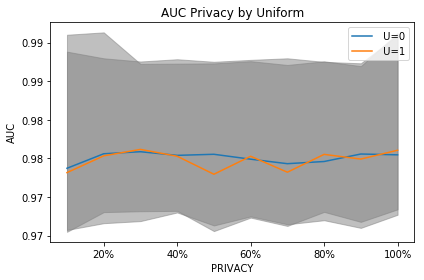

In [6]:
plot_intervals(supervised_results, "privacy","auc", {}, 
               {"real":["t", "f", "m"]}, savefig=True, 
               title="AUC Privacy by Real", save_name="auc_real_privacy")

plot_intervals(supervised_results, "privacy","auc", {}, 
               {"uniform":[0,1]}, savefig=True, 
               title="AUC Privacy by Uniform", save_name="auc_uniform_privacy")

/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


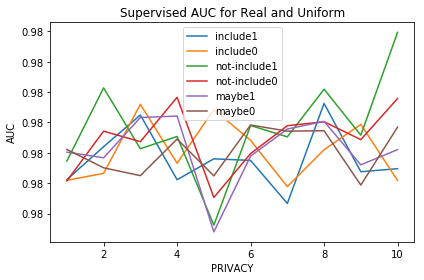

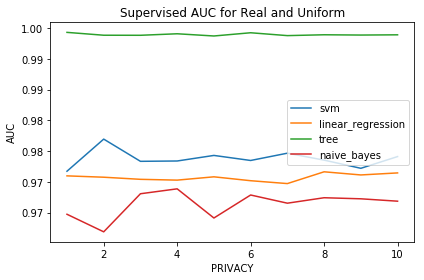

In [8]:
rmse_auc_plot_no_intervals(supervised_results, "privacy", "auc", ["t", "f", "m"], [None], [None], [None], [None],
                           {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=True, 
                           title="Supervised AUC for Real and Uniform", save_name="supervised_auc_gb_tmf_01")

rmse_auc_plot_no_intervals(supervised_results, "privacy", "auc", [None], [None], [None], [None], ["svm", "linear_regression", "tree", "naive_bayes"],
                           savefig=True, title="Supervised AUC for Real and Uniform", save_name="supervised_auc_models")

### AUC Table

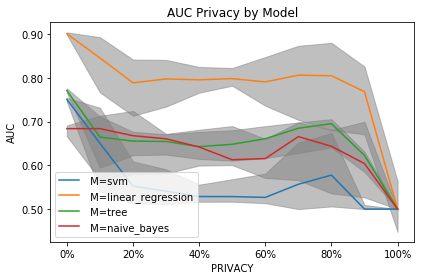

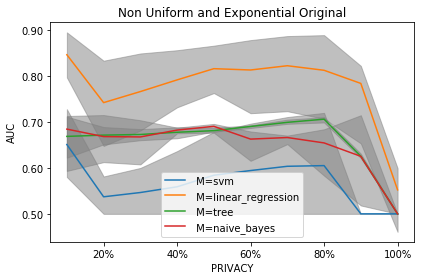

In [7]:
plot_intervals(supervised_results, "privacy","auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=True, 
               title="AUC Privacy by Model", save_name="income_auc_model_privacy")

plot_intervals(supervised_results, "privacy","auc", {"uniform": [0], "uniform2":[0], "uniform_original":[0]}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=False, 
               title="Non Uniform and Exponential Original", save_name="auc_nclasses00")

In [ ]:
plot_intervals(supervised_results, "real", "auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=False, 
               title="Non Uniform and Exponential Original", save_name="auc_isreal")